In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import pandas as pd
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [2]:
results_dirs = {
    "mtsNFVS": "../benchmark/results-nfvs/",
    "AEON.py": "../benchmark/results-aeon/",
    "biobalm": "../benchmark/results-0.2.0/",
    "biobalm (block)": "../benchmark/results-0.2.0/",
}

nk3_fnames = {  # will make others when they are ready
    "all": "random-nk3.csv",
    "biobalm-expand": "random-nk3-full-expand.csv",
    "biobalm-search": "random-nk3-full-attractors.csv",
    "biobalm (block)": "random-nk3-block-attractors.csv",
}

colors = {
    "mtsNFVS": "#DDAA33",
    "AEON.py": "#BB5566",
    "biobalm": "#004488",
    "biobalm (block)": "#66aadd",
}

In [79]:
df_test = pd.read_csv(
    results_dirs["biobalm (block)"] + nk3_fnames["biobalm (block)"],
    header=None,
    skiprows=1,
    names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"],
)
df_test.fillna(0.0, inplace=True)
df_test["Attractors"]

0       2.0
1       5.0
2       1.0
3       2.0
4       5.0
       ... 
2395    2.0
2396    4.0
2397    2.0
2398    3.0
2399    1.0
Name: Attractors, Length: 2400, dtype: float64

In [84]:
df_test['Attractors'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
2395    False
2396    False
2397    False
2398    False
2399    False
Name: Attractors, Length: 2400, dtype: bool

Success rate for mtsNFVS: Notes
True     2381
False      19
Name: count, dtype: int64
Success rate for AEON: Attractors
True     2014
False      86
Name: count, dtype: int64
Success rate for biobalm: Attractors
True     2392
False       8
Name: count, dtype: int64
Success rate for biobalm(block): Attractors
True     2395
False       5
Name: count, dtype: int64


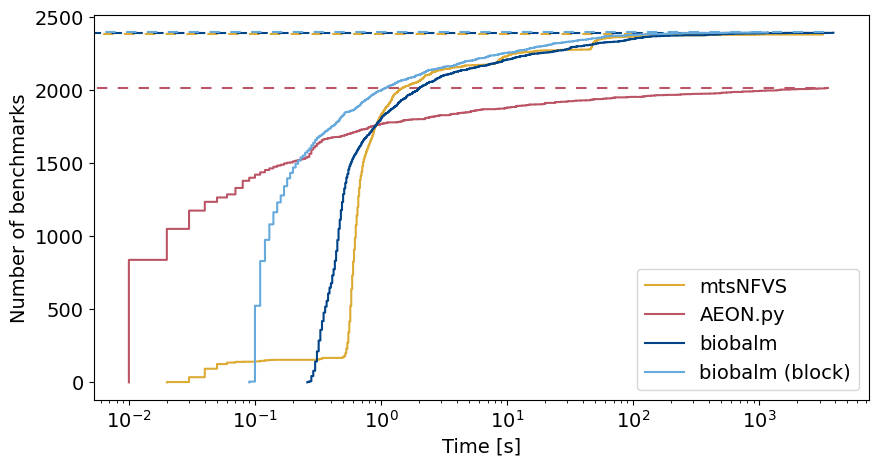

In [93]:
def plot_cumulative(dirs, fnames, colors):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.set_facecolor("white")

    for i, (tool, dir) in enumerate(dirs.items()):
        if tool == "mtsNFVS":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Notes"],
            ) 
            df.fillna("", inplace=True)
            # The benchmark is a success if the note contains one of two pre-defined values.
            success_rows = df['Notes'].str.contains(r'Number of attractors|Network solved')
            print("Success rate for mtsNFVS:", success_rows.value_counts())
            df.loc[~success_rows, 'Time[s]'] = "inf"
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            t = df["Time[s]"].sort_values()
        elif tool == "AEON.py":            
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Attractors", "Attractor states"],
            )
            df.fillna("", inplace=True)
            # The benchmark is a success if "Attractors" is exactly one number.
            success_rows = df['Attractors'].str.match(r'^\s*\d+$')
            print("Success rate for AEON:", success_rows.value_counts())
            df.loc[~success_rows, 'Time[s]'] = float("inf")
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            t = df["Time[s]"].sort_values()
        elif tool == "biobalm (block)":
            df = pd.read_csv(
                dirs[tool] + fnames["biobalm (block)"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"],
            )
            # The benchmark is a success if "Attractors" is defined.
            success_rows = ~df['Attractors'].isna()
            print("Success rate for biobalm(block):", success_rows.value_counts())
            df.loc[~success_rows, 'Time[s]'] = float("inf")
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            t = df["Time[s]"].sort_values()
        elif tool == "biobalm":
            df_exp = pd.read_csv(
                dirs[tool] + fnames["biobalm-expand"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps"],
            )
            success_rows = ~df_exp['Minimal traps'].isna()
            df_exp.loc[~success_rows, 'Time[s]'] = float("inf")
            df_exp["Time[s]"] = df_exp["Time[s]"].apply(lambda x: float(x))
            
            df_att = pd.read_csv(
                dirs[tool] + fnames["biobalm-search"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Minimal traps", "Attractors", "MAAs"],
            )
            # The benchmark is a success if "Attractors" is defined (if expansion failed, 
            # this will fail too, so no need to check both).
            success_rows = ~df_att['Attractors'].isna()
            df_att.loc[~success_rows, 'Time[s]'] = float("inf")
            df_att["Time[s]"] = df_att["Time[s]"].apply(lambda x: float(x))
            
            print("Success rate for biobalm:", success_rows.value_counts())
            
            t = (df_exp["Time[s]"] + df_att["Time[s]"]).sort_values()            
        else:
            print(f"SKIPPING {tool}")
            continue
        successes = sum(t < float("inf"))        
        ax.hlines(
            y=successes,
            xmin=0,
            xmax=3600,
            color=colors[tool],
            linestyle=(i * 3, (5, 5)),
        )
        ax.step(t, np.arange(len(t)), label=tool, c=colors[tool])

    ax.set_xscale("log")

    ax.set_xlabel("Time [s]", fontsize=14)
    ax.set_ylabel("Number of benchmarks", fontsize=14)

    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14, loc="lower right")


plot_cumulative(results_dirs, nk3_fnames, colors)

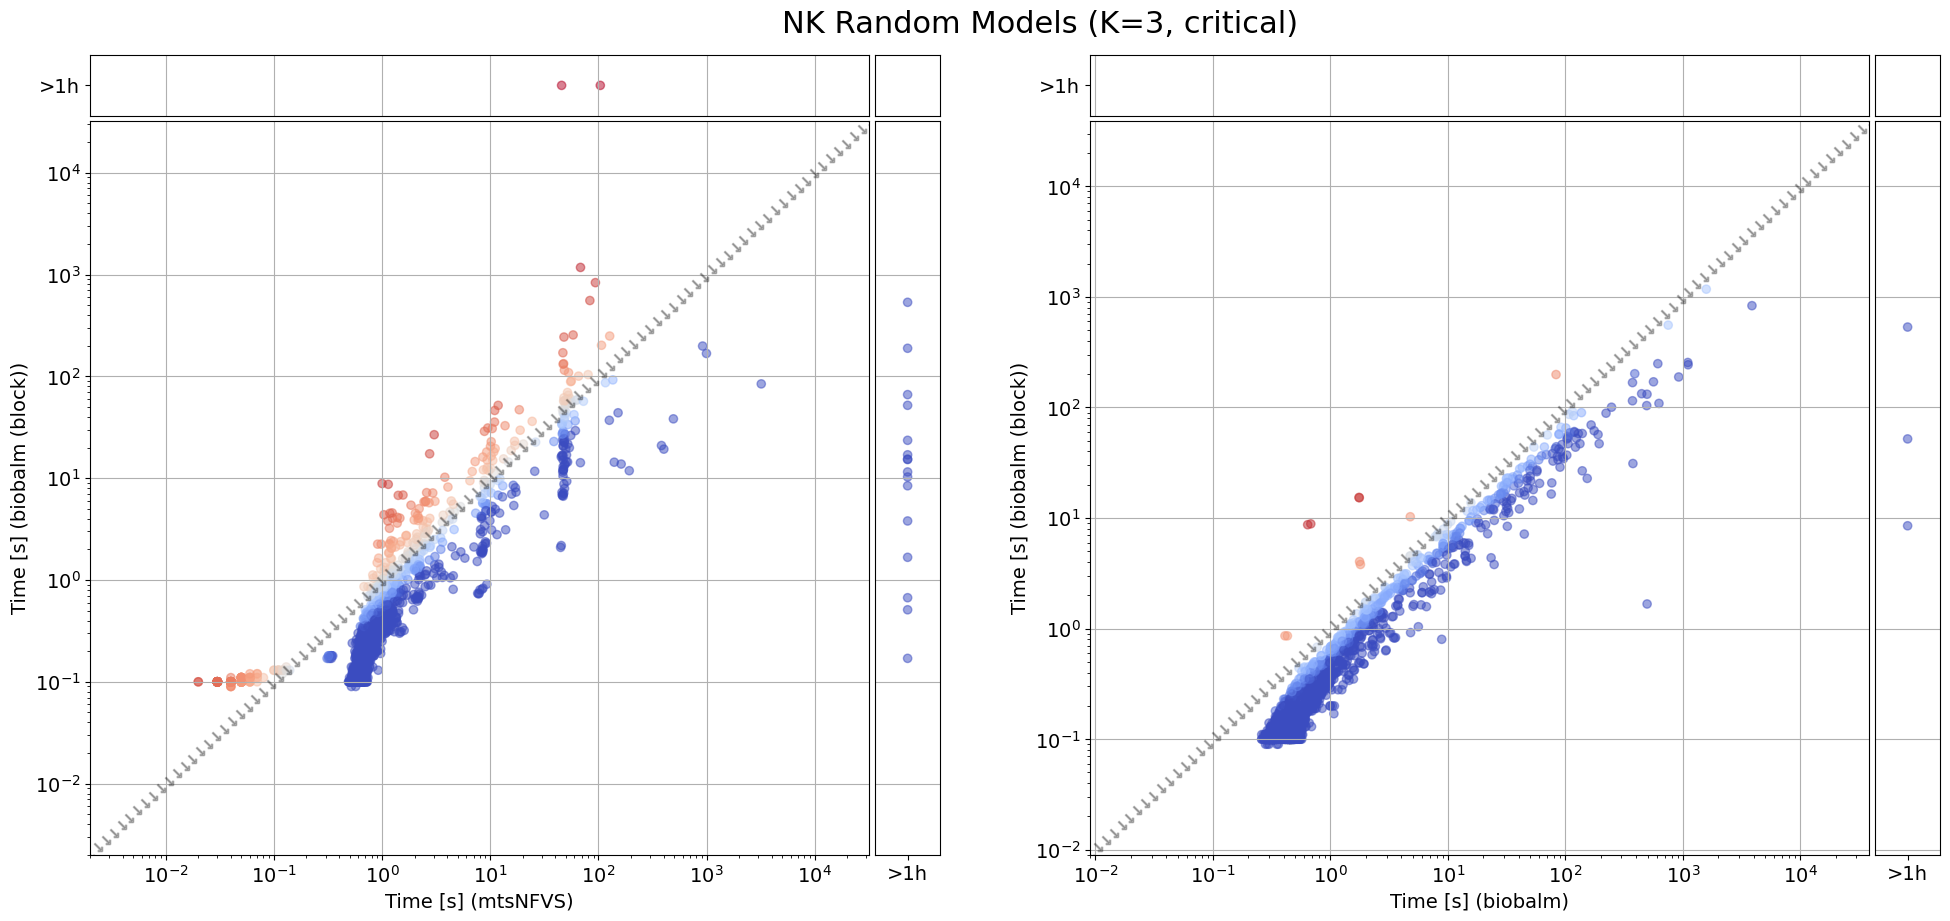

In [101]:
def plot_scatter(dirs, fnames, title=""):
    stretch_factor = 12
    fig = plt.figure(figsize=(20, 10))

    fig.set_facecolor("white")
    figs = fig.subfigures(1, 2)
    # for afig, tool in zip(figs.flatten(), ["mtsNFVS", "AEON.py"]):
    for afig, tool in zip(figs.flatten(), ["mtsNFVS", "biobalm"]):
        if tool == "mtsNFVS":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Notes"],
            )
            df.fillna("", inplace=True)
            # The benchmark is a success if the note contains one of two pre-defined values.
            success_rows = df['Notes'].str.contains(r'Number of attractors|Network solved')
            df.loc[~success_rows, 'Time[s]'] = "inf"
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        elif tool == "AEON.py":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Attractors", "Attractor states"],
            )
            df.fillna("", inplace=True)
            # The benchmark is a success if "Attractors" is exactly one number.
            success_rows = df['Attractors'].str.match(r'^\s*\d+$')
            print("Success rate for AEON:", success_rows.value_counts())
            df.loc[~success_rows, 'Time[s]'] = float("inf")
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        elif tool == "biobalm (block)":
            df = pd.read_csv(
                dirs[tool] + fnames["biobalm (block)"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"],
            )
            # The benchmark is a success if "Attractors" is defined.
            success_rows = ~df['Attractors'].isna()
            df.loc[~success_rows, 'Time[s]'] = float("inf")
            df["Time[s]"] = df["Time[s]"].apply(lambda x: float(x))
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        elif tool == "biobalm":
            df_exp = pd.read_csv(
                dirs[tool] + fnames["biobalm-expand"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps"],
            )
            success_rows = ~df_exp['Minimal traps'].isna()
            df_exp.loc[~success_rows, 'Time[s]'] = float("inf")
            df_exp["Time[s]"] = df_exp["Time[s]"].apply(lambda x: float(x))
            
            df_att = pd.read_csv(
                dirs[tool] + fnames["biobalm-search"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "All nodes", "Minimal traps", "Attractors", "MAAs"],
            )
            
            # The benchmark is a success if "Attractors" is defined (if expansion failed, 
            # this will fail too, so no need to check both).
            success_rows = ~df_att['Attractors'].isna()
            df_att.loc[~success_rows, 'Time[s]'] = float("inf")
            df_att["Time[s]"] = df_att["Time[s]"].apply(lambda x: float(x))
            
            df.sort_values(by="Benchmark", inplace=True)
            t = df_exp["Time[s]"] + df_att["Time[s]"]
        
        df_compare = pd.read_csv(
            dirs["biobalm (block)"] + fnames["biobalm (block)"],
            header=None,
            skiprows=1,
            names=["Benchmark", "Time[s]", "All nodes", "Expanded nodes", "Minimal traps", "Attractors", "MAAs"],
        )
        
        # The benchmark is a success if "Attractors" is defined.
        success_rows = ~df_compare['Attractors'].isna()
        df_compare.loc[~success_rows, 'Time[s]'] = float("inf")
        df_compare["Time[s]"] = df_compare["Time[s]"].apply(lambda x: float(x))
        
        df_compare.sort_values(by="Benchmark", inplace=True)
        t_bb = df_compare["Time[s]"]

        axd = afig.subplot_mosaic(
            [
                ["BBTimeout", "BothTimeout"],
                ["BothRan", "CompTimeout"],
            ],
            gridspec_kw={
                "width_ratios": [stretch_factor, 1],
                "height_ratios": [1, stretch_factor],
            },
        )

        axd["BothRan"].scatter(
            t,
            t_bb,
            c=t / t_bb,
            alpha=0.5,
            norm=CenteredNorm(vcenter=1, halfrange=1),
            cmap="coolwarm_r",
        )

        tmax = max(t[t < float("inf")].max(), t_bb[t_bb < float("inf")].max()) * 10.0
        tmin = min(t[t < float("inf")].min(), t_bb[t_bb < float("inf")].min()) / 10.0
        axd["BothRan"].set_xlim(tmin, tmax)
        axd["BothRan"].set_ylim(tmin, tmax)
        axd["BothRan"].set_xscale("log")
        axd["BothRan"].set_yscale("log")

        axd["BothRan"].set_xlabel(f"Time [s] ({tool})", fontsize=14)
        axd["BothRan"].set_ylabel("Time [s] (biobalm (block))", fontsize=14)
        axd["BothRan"].tick_params(labelsize=14, gridOn=True)

        boundary_pts = np.logspace(np.log10(tmin), np.log10(tmax), 100)
        axd["BothRan"].plot(
            boundary_pts,
            boundary_pts,
            color="black",
            linestyle="",
            marker=r"$\searrow$",
            alpha=0.25,
        )

        axd["BBTimeout"].scatter(
            t[t_bb == float("inf")],
            0 * t[t_bb == float("inf")],
            norm=CenteredNorm(vcenter=1, halfrange=0.5),
            c=0 * t[t_bb == float("inf")],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["BBTimeout"].sharex(axd["BothRan"])
        axd["BBTimeout"].set_xscale("log")
        axd["BBTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )
        axd["BBTimeout"].tick_params(axis="x", gridOn=True)
        axd["BBTimeout"].tick_params(axis="y", tick1On=True, labelleft=True)
        axd["BBTimeout"].set_yticks([0])
        axd["BBTimeout"].set_yticklabels([">1h"], fontsize=14)

        axd["CompTimeout"].scatter(
            0 * t_bb[t == float("inf")],
            t_bb[t == float("inf")],
            norm=CenteredNorm(vcenter=-1, halfrange=0.5),
            c=0 * t_bb[t == float("inf")],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["CompTimeout"].sharey(axd["BothRan"])
        axd["CompTimeout"].set_yscale("log")
        axd["CompTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )
        axd["CompTimeout"].tick_params(axis="y", gridOn=True)
        axd["CompTimeout"].tick_params(axis="x", tick1On=True, labelbottom=True)
        axd["CompTimeout"].set_xticks([0])
        axd["CompTimeout"].set_xticklabels([">1h"], fontsize=14)

        axd["BothTimeout"].scatter(
            0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            norm=CenteredNorm(vcenter=0, halfrange=0.5),
            c=0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["BothTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )

        afig.subplots_adjust(hspace=0.0135, wspace=0.0135)

    fig.subplots_adjust(bottom=0.08, left=0.05)
    fig.suptitle(title, fontsize=22, y=0.925)


plot_scatter(results_dirs, nk3_fnames, title="NK Random Models (K=3, critical)")